In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vaex

from astropy.io import fits
from astropy.wcs import WCS
from itertools import product
from m33_utils import open_and_select, deg_to_deproj
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
from matplotlib import patheffects

np.seterr(all='ignore')

sns.set(style='ticks', 
        rc={'font.family'          : 'serif',
            'text.usetex'          : True,
            'axes.axisbelow'       : True,
            'mathtext.fontset'     : 'cm',
            'mathtext.default'     : 'regular',
            'xtick.direction'      : 'in',
            'ytick.direction'      : 'in',
            'xtick.major.width'    : 1.1,
            'ytick.major.width'    : 1.1,
            'axes.labelpad'        : 5.0,
            'legend.framealpha'    : 0.95,
            'legend.handlelength'  : 1.2,
            'legend.handletextpad' : 0.5,
       })

pal = sns.color_palette('colorblind')
dark = sns.color_palette('dark')
sns.set_palette(pal)

def add_colorbar(fig, ax, cmap='viridis', vmin=0, vmax=1,
                 norm='Normalize', n_colors=None, norm_args={},
                 offset=0.0175, width=0.0225, label='Number of stars'):
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+offset, pos.y0, width, pos.height])
    cmap_mpl = plt.get_cmap(cmap, n_colors)
    norm_mpl = getattr(mpl.colors, norm)(**norm_args, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_mpl, cmap=cmap_mpl),
                        cax=cax, label=label)
    return cbar

In [2]:
ds = open_and_select('../legacy_phot/M33_full_matched.hdf5')

In [4]:
df_cl = pd.read_csv('data/clusters_withfield.csv', index_col=0)
df_cl

,RA,Dec,Radius
ID,,,
2,23.611876,30.696172,1.66
8,23.479685,30.799434,3.18
11,23.445514,30.766325,1.70
15,23.577713,30.527063,2.60
17,23.524192,30.832463,2.51
19,23.515814,30.492593,2.36
25,23.506395,30.708606,2.16
27,23.537176,30.609388,2.23


In [67]:
for idx, row in df_cl.iterrows():
    ds.select_circle('RA', 'DEC', row.RA, row.Dec, row.Radius/3600, name=f'cluster_{idx}')
    print(idx, ds.selected_length(f'cluster_{idx}'))

2 0
8 780
11 258
15 439
17 434
19 0
25 423
27 393


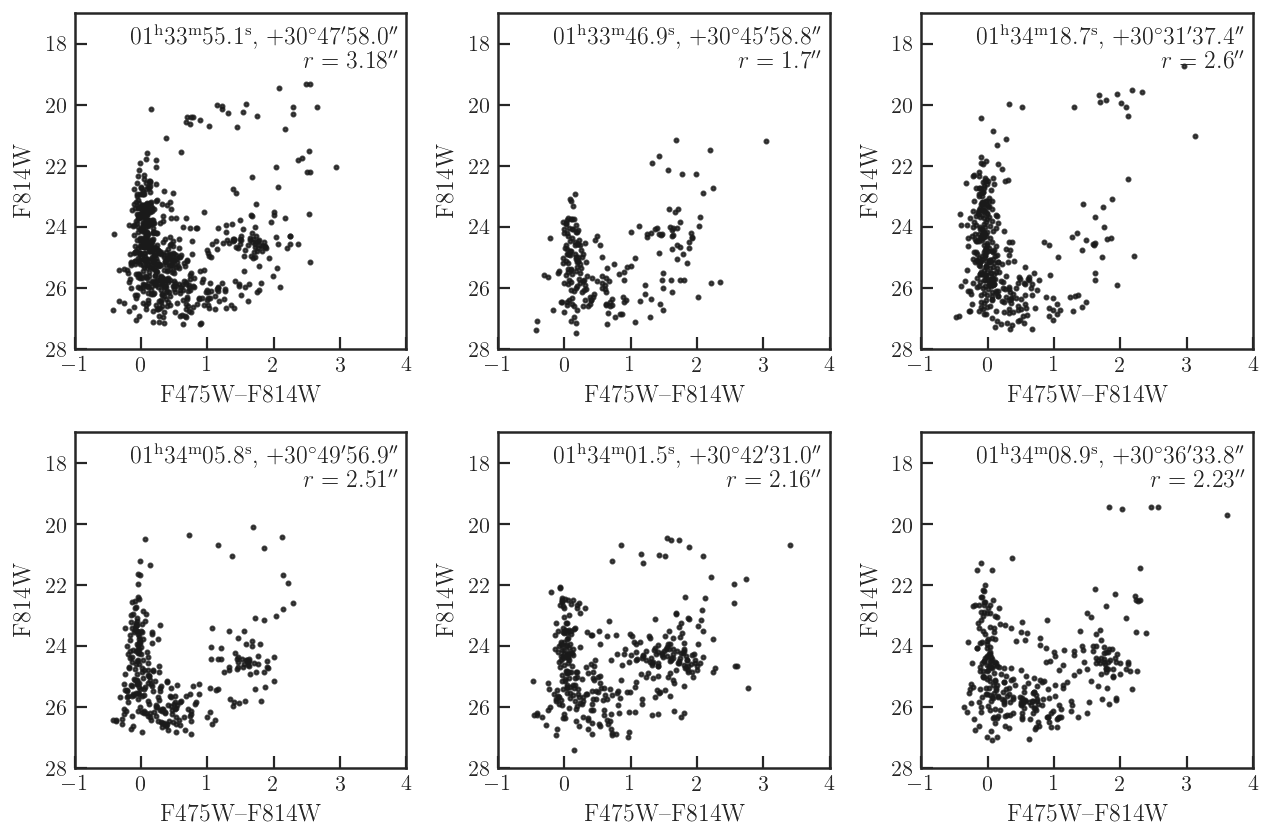

In [65]:
from astropy.coordinates import SkyCoord

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flat

for i, (idx, row) in enumerate(df_cl.drop([2, 19]).iterrows()):
    ax = axes[i]
    plt.sca(ax)
    ds.scatter('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', selection=f'OPT_GST & cluster_{idx}',
               color='k', s=4, alpha=0.8)
    ax.set_xlabel('F475W--F814W')
    ax.set_ylabel('F814W')
    ax.set_xlim(-1, 4)
    ax.set_ylim(28, 17)
    ra, dec = SkyCoord(row.RA, row.Dec, unit='deg'
                      ).to_string('hmsdms', decimal=False, precision=1, format='latex'
                                 ).replace('{','{{').replace('}','}}').split()
    ax.text(0.97, 0.97, f'{ra}, {dec}\n$r={row.Radius}^{{\prime\prime}}$',
            va='top', ha='right', transform=ax.transAxes)
fig.tight_layout()

In [88]:
df_lggs = pd.read_csv('data/m33_lggs.tsv', sep=';', comment='#', na_values=[' '*i for i in range(10)])
df_lggs['Bmag'] = df_lggs['Vmag']+df_lggs['B-V']
df_lggs['Rmag'] = df_lggs['Vmag']-df_lggs['V-R']
df_lggs['Imag'] = df_lggs['Rmag']-df_lggs['R-I']
df_lggs = df_lggs[df_lggs.Imag.notna()]
df_lggs.rename(lambda x: x.replace('-','_'), axis='columns', inplace=True)
ds_lggs = vaex.from_pandas(df_lggs)
ds_lggs.length()

72408

In [89]:
ds_lggs

#,RA,DEC,LGGS,LBV,Rgc,Vmag,e_Vmag,B_V,e_B_V,U_B,e_U_B,V_R,e_V_R,R_I,e_R_I,Cwd,Mm,SpT,Bmag,Rmag,Imag
0,23.3400417,30.5422222,J013321.64+303232.1,nan,0.34,22.98,0.307,0.067,0.384,0.516,0.441,0.402,0.36,0.725,0.188,I,nan,nan,23.047,22.578,21.852999999999998
1,23.3400417,30.562833299999998,J013321.64+303346.3,nan,0.33,21.701,0.02,1.224,0.06,0.616,0.46,0.635,0.025,0.7,0.013999999999999999,I,nan,nan,22.925,21.066,20.366
2,23.3400417,30.59625,J013321.64+303546.6,nan,0.32,21.776999999999997,0.03,0.002,0.040999999999999995,-0.504,0.032,0.16699999999999998,0.059000000000000004,0.114,0.051,C,nan,nan,21.778999999999996,21.609999999999996,21.495999999999995
3,23.3400417,30.661944399999996,J013321.64+303943.1,nan,0.35,22.281,0.049,0.396,0.10400000000000001,-0.268,0.106,0.423,0.075,0.675,0.055999999999999994,I,nan,nan,22.677,21.858,21.183
4,23.3400833,30.558111100000005,J013321.65+303329.3,nan,0.33,22.526999999999997,0.091,0.833,0.203,nan,nan,0.536,0.109,0.932,0.06,I,nan,nan,23.359999999999996,21.990999999999996,21.058999999999997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"72,403",23.6629583,30.5834722,J013439.14+303500.6,nan,0.66,20.43,0.01,0.201,0.013999999999999999,0.166,0.013999999999999999,0.11199999999999999,0.013000000000000001,0.235,0.009000000000000001,I,nan,nan,20.631,20.318,20.083000000000002
"72,404",23.6629583,30.6337222,J013439.14+303801.5,nan,0.6,22.281999999999996,0.08800000000000001,-0.165,0.113,-0.474,0.077,0.076,0.165,-0.124,0.17300000000000001,I,nan,nan,22.116999999999997,22.205999999999996,22.329999999999995
"72,405",23.6629583,30.692861100000002,J013439.14+304134.4,nan,0.54,20.784000000000002,0.018000000000000002,-0.019,0.022000000000000002,-1.022,0.016,0.04,0.024,-0.08900000000000001,0.016,C,nan,nan,20.765000000000004,20.744000000000003,20.833000000000002
"72,406",23.6629583,30.773055600000003,J013439.14+304623.1,nan,0.52,21.654,0.025,-0.16399999999999998,0.033,-0.903,0.021,-0.016,0.043,-0.111,0.039,I,nan,nan,21.49,21.669999999999998,21.781


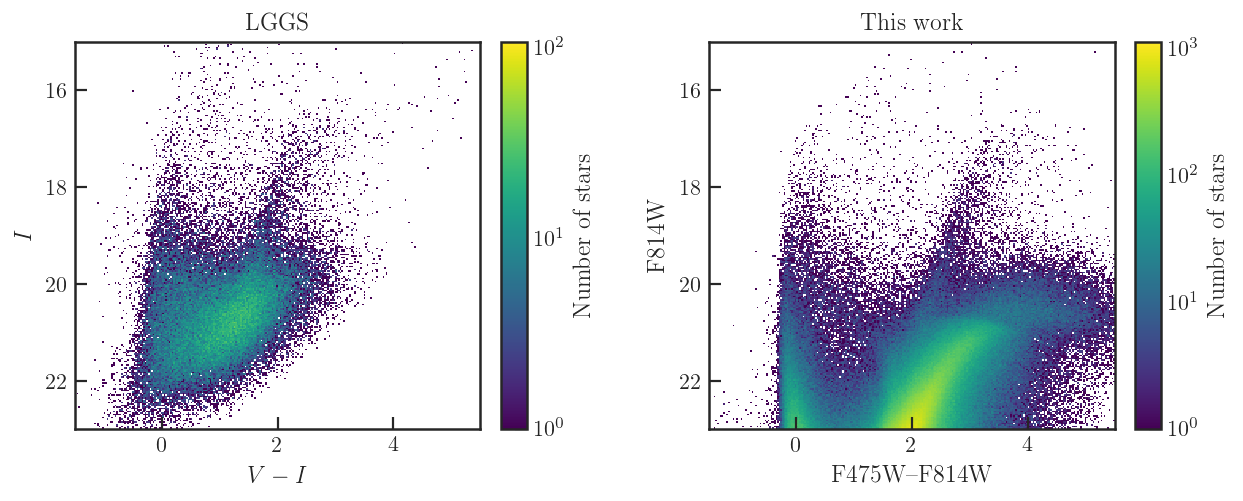

In [117]:
lim = [[-1.5, 5.5], [23, 15]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
plt.sca(ax1)
ds_lggs.plot('Vmag-Imag', 'Imag', f='log10', limits=lim, vmin=0, vmax=2.03, #shape=420,
             xlabel='$V-I$', ylabel='$I$', colormap='viridis', colorbar=False)

plt.sca(ax2)
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', vmin=0, vmax=3.05, f='log10', selection='OPT_GST',
        xlabel='F475W--F814W', ylabel='F814W', colormap='viridis', limits=lim, colorbar=False)

fig.tight_layout(w_pad=7)
add_colorbar(fig, ax1, cmap='viridis', vmin=1, vmax=10**2.03,
             norm='LogNorm', label='Number of stars')
add_colorbar(fig, ax2, cmap='viridis', vmin=1, vmax=10**3.05,
             norm='LogNorm', label='Number of stars')

ax1.set_yticks([16, 18, 20, 22])
ax2.set_yticks([16, 18, 20, 22])
ax1.set_title('LGGS')
ax2.set_title('This work')
fig.savefig('figures/LGGS_comparison.pdf', dpi=300, bbox_inches='tight')

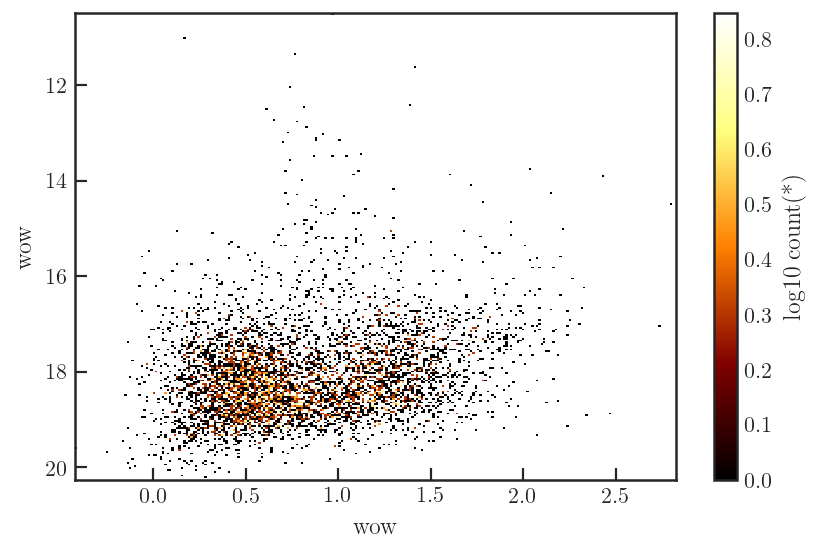

In [6]:
ds_gaia = vaex.from_csv('../gaia_all.csv')
ds_gaia.plot('bp_rp', 'phot_rp_mean_mag', f='log10', xlabel='wow', ylabel='wow')
plt.gca().invert_yaxis()

/astro/users/mdurbin/miniconda3/envs/astroconda_dev/lib/python3.7/site-packages/vaex/viz/mpl.py:779: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = pylab.subplot(gs[row_offset + row * row_scale:row_offset + (row + 1) * row_scale, column * column_scale:(column + 1) * column_scale])


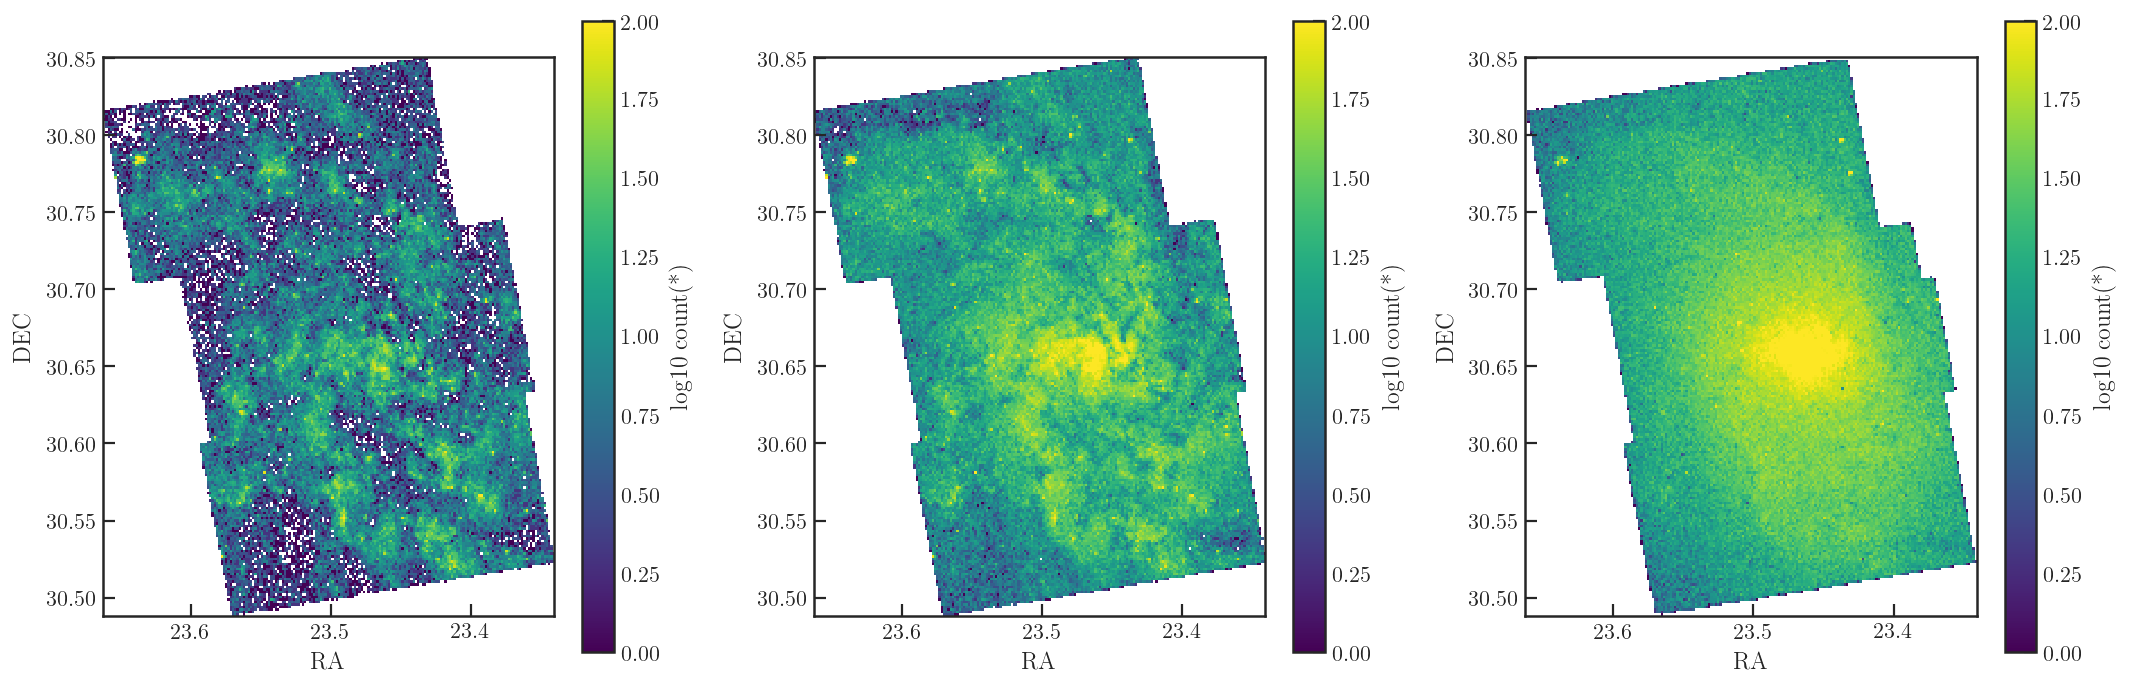

In [7]:
# 0.9+       &  24.14 &  25.10 &  25.78 &  25.39 &  23.72 &  23.04 \\
ds.plot('RA', 'DEC', limits='minmax', aspect=1.1, figsize=(15,5), tight_layout=True,
        shape=(200,220), vmin=0, vmax=2, f='log10',
        visual=dict(column='selection'), 
        selection=['(F275W_VEGA < 24.0) & (F336W_VEGA < 25) & UV_GST',
                   '(F475W_VEGA < 24.5) & (F814W_VEGA < 24) & OPT_GST',
                   '(F110W_VEGA < 22.5) & (F160W_VEGA < 22) & IR_GST'],
        colormap='viridis')
for ax in plt.gcf().get_axes():
    ax.invert_xaxis()

In [8]:
distA, distB = deg_to_deproj(*ds[['RA','DEC']].values.T)

In [9]:
ds['distA'] = distA
ds['distB'] = distB
ds['radius'] = (distA**2 + distB**2)**0.5

In [10]:
for density in [[0, 0.15], [0.15, 0.3], [0.3, 0.6], [0.6, 0.9], [0.9, 1000]]:
    rad = ds.median_approx('radius', binby='DENSITY', shape=1, limits=density, percentile_shape=10000,
                           percentile_limits='minmax', selection='(F160W_VEGA < 20.7) & (F160W_VEGA > 19.7)')
    print(density, rad.round(3)[0])

[0, 0.15] 2.679
[0.15, 0.3] 1.751
[0.3, 0.6] 0.908
[0.6, 0.9] 0.379
[0.9, 1000] 0.152


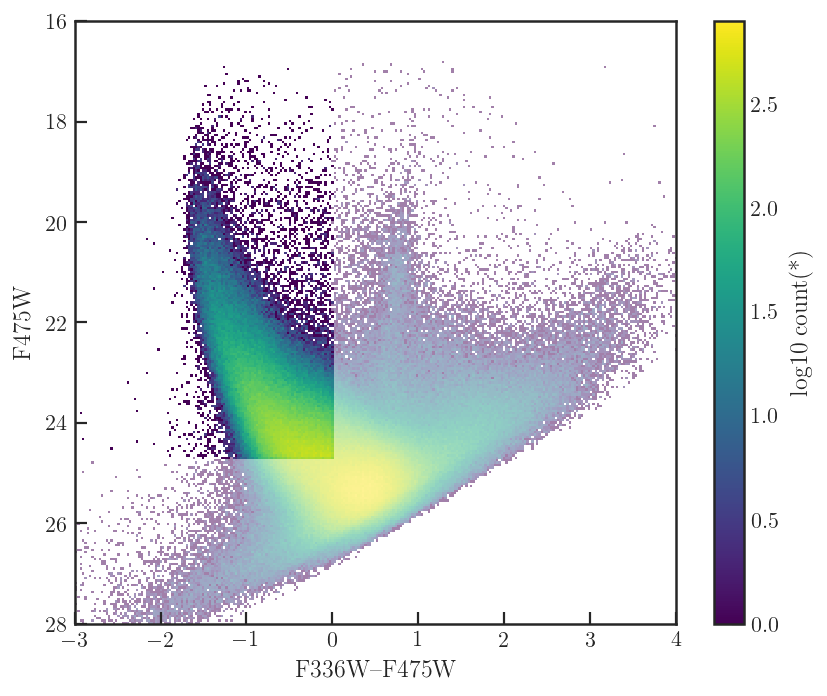

In [11]:
ds.plot('F336W_VEGA-F475W_VEGA', 'F475W_VEGA', f='log10', xlabel='F336W--F475W', ylabel='F475W',
        limits=[[-3,4], [28, 16]], colormap='viridis', figsize=(6,5),
        selection=['F336W_GST & F475W_GST',
                   '(F475W_VEGA < 24.7) & (F336W_VEGA-F475W_VEGA < 0) & F336W_GST & F475W_GST'])

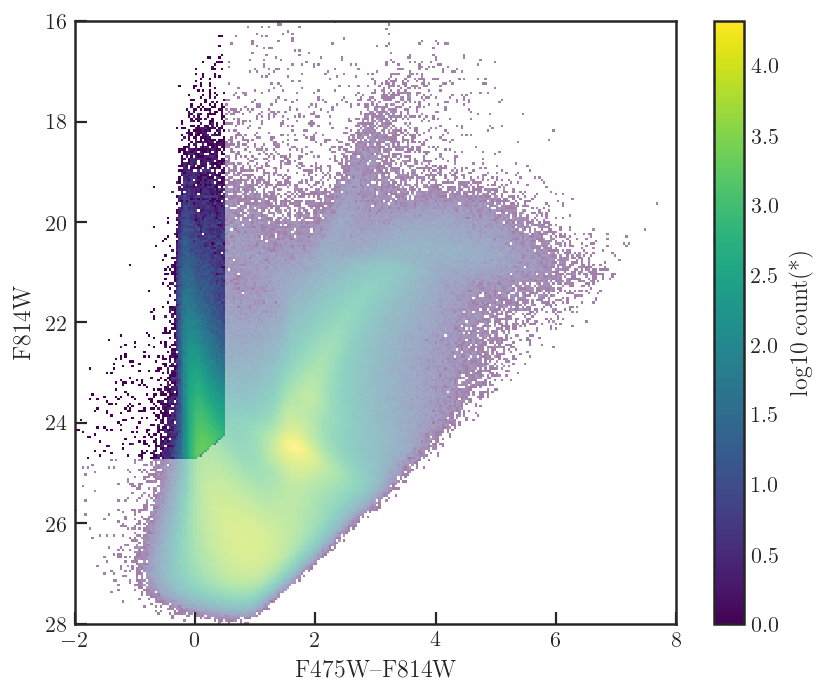

In [16]:
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', f='log10', xlabel='F475W--F814W', ylabel='F814W',
        limits=[[-2,8], [28, 16]], colormap='viridis', figsize=(6,5),
        selection=['OPT_GST',
                   '(F475W_VEGA < 24.7) & (F814W_VEGA < 24.7) & (F475W_VEGA-F814W_VEGA < 0.5) & OPT_GST'])

In [17]:
ob_opt = '(F475W_VEGA < 24.7) & (F814W_VEGA < 24.7) & (F475W_VEGA-F814W_VEGA < 0.5) & OPT_GST'
ds.selected_length(ob_opt)

427454

In [15]:
ob_selection = '(F475W_VEGA < 24.7) & (F336W_VEGA-F475W_VEGA < 0)'
ob_selection += ' & (F336W_VEGA-F475W_VEGA > -3) & F336W_GST & F475W_GST'
ds.selected_length(ob_selection)

329522

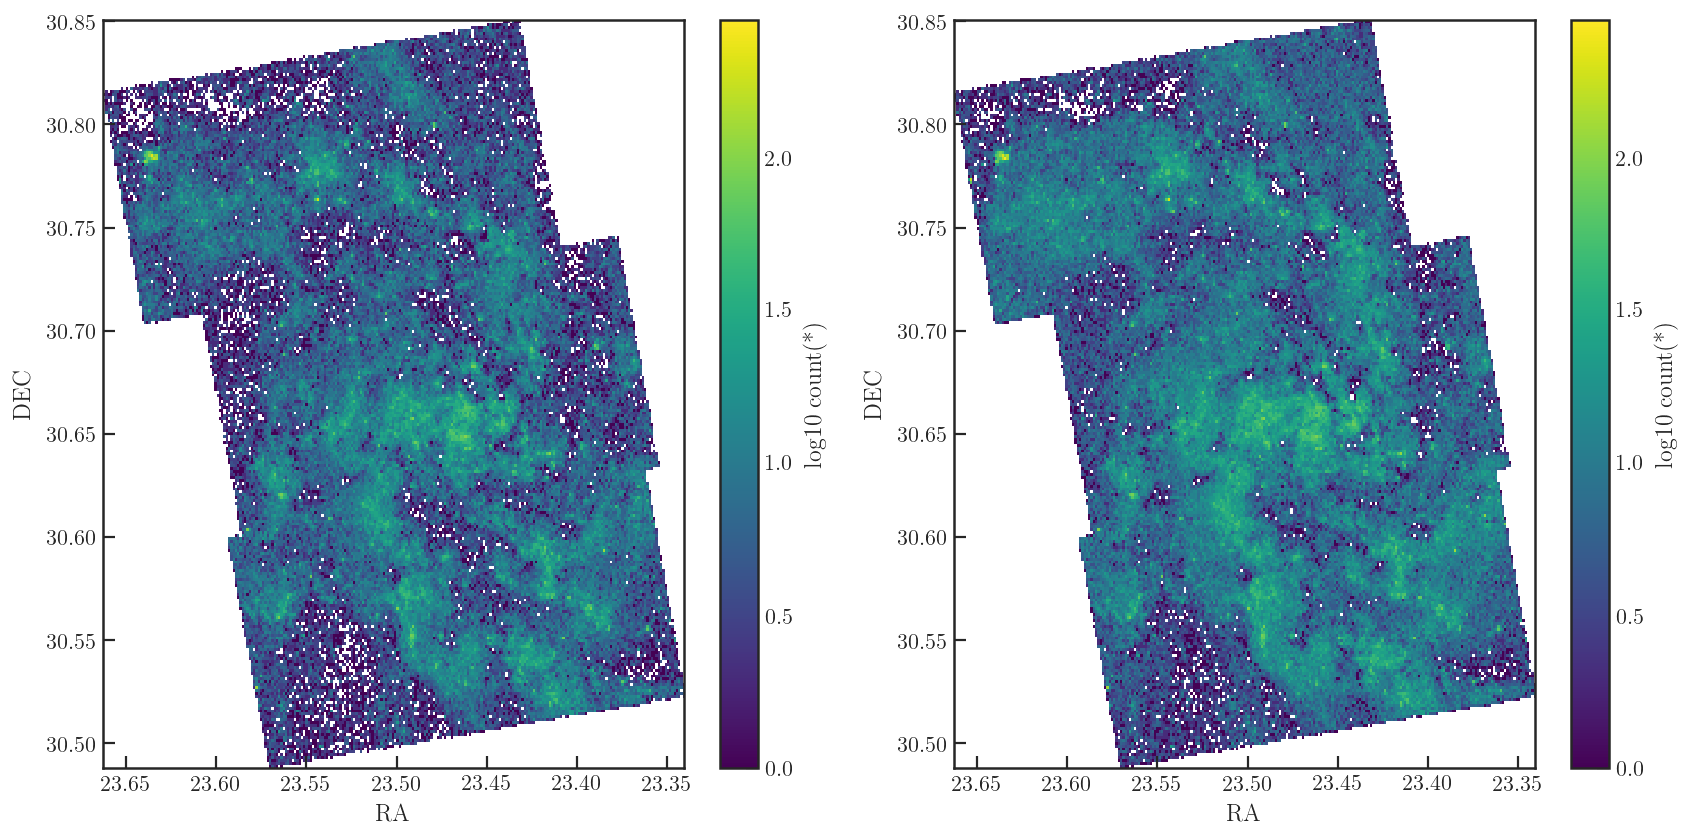

In [18]:
ds.plot('RA', 'DEC', f='log10', #xlabel='F336W--F475W', ylabel='F475W',
        limits='minmax', colormap='viridis', figsize=(12,6),
        selection=[ob_selection, ob_opt], visual=dict(column='selection'))
for ax in plt.gcf().get_axes():
    ax.invert_xaxis()

In [28]:
329522 / 3

109840.66666666667

In [19]:
ds_m31 = open_and_select('../../phat_legacy/M31.hdf5')

In [22]:
# M31: 10.68333, 41.26917, 77.5, 37.5, 24.45
distA, distB = deg_to_deproj(*ds_m31[['RA','DEC']].values.T,
                             ra0=10.68333, dec0=41.26917, i_deg=77.5,
                             pa_deg=37.5, dmod=24.45)
ds_m31['distA'] = distA
ds_m31['distB'] = distB
ds_m31['radius'] = (distA**2 + distB**2)**0.5

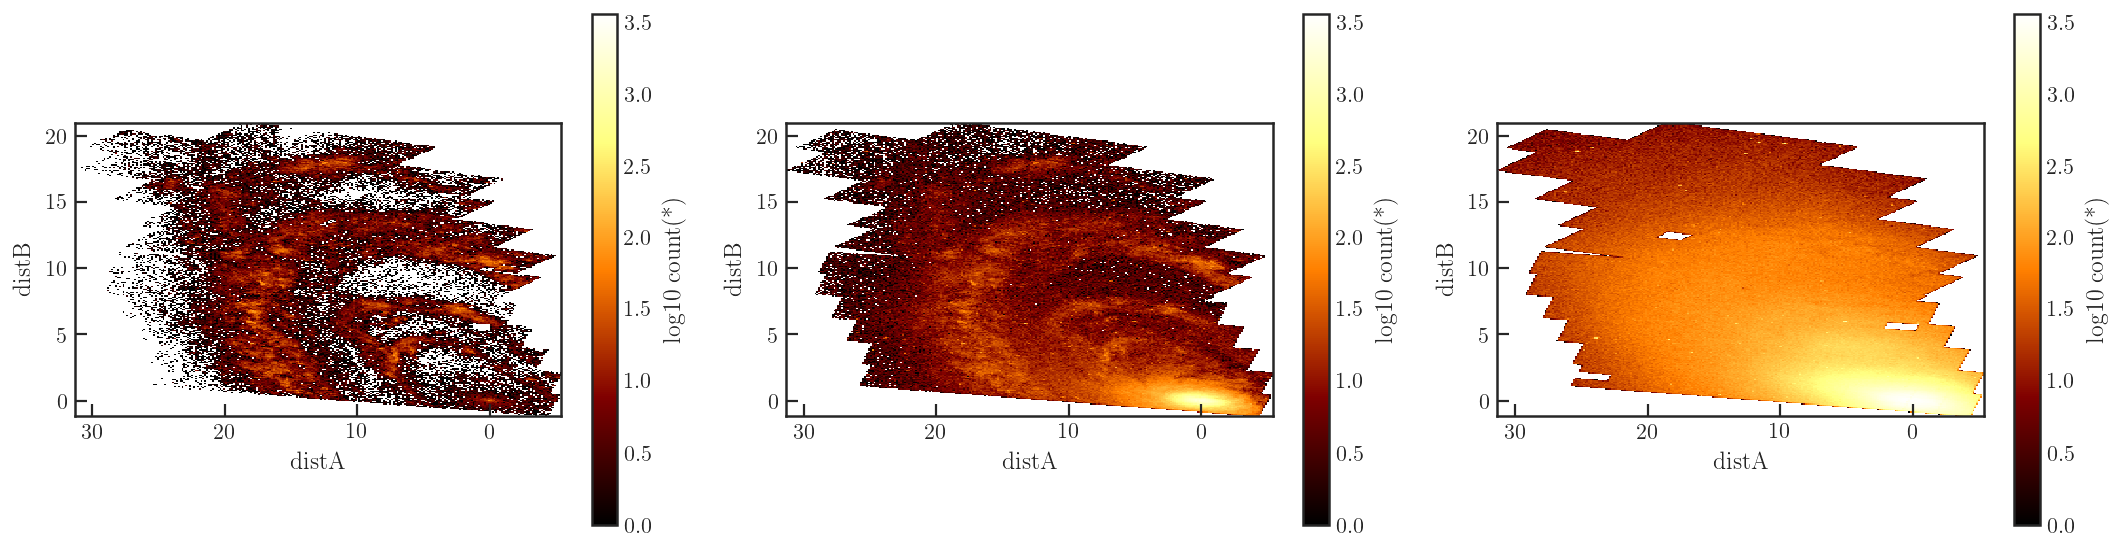

In [32]:
ds_m31.plot('distA', 'distB', f='log10', aspect=1, #limits=[0, 20],
            visual=dict(column='selection'), figsize=(15,4),
            selection=['(F275W_VEGA < 24.0) & (F336W_VEGA < 25) & UV_GST',
                       '(F475W_VEGA < 24.0) & (F814W_VEGA < 23.5) & OPT_GST',
                       '(F110W_VEGA < 21.5) & (F160W_VEGA < 21) & IR_GST'],
            wrap_columns=2,
)
for ax in plt.gcf().get_axes():
    ax.invert_xaxis()

In [24]:
ob_m31 = ob_selection.replace('24.7', '24.5')

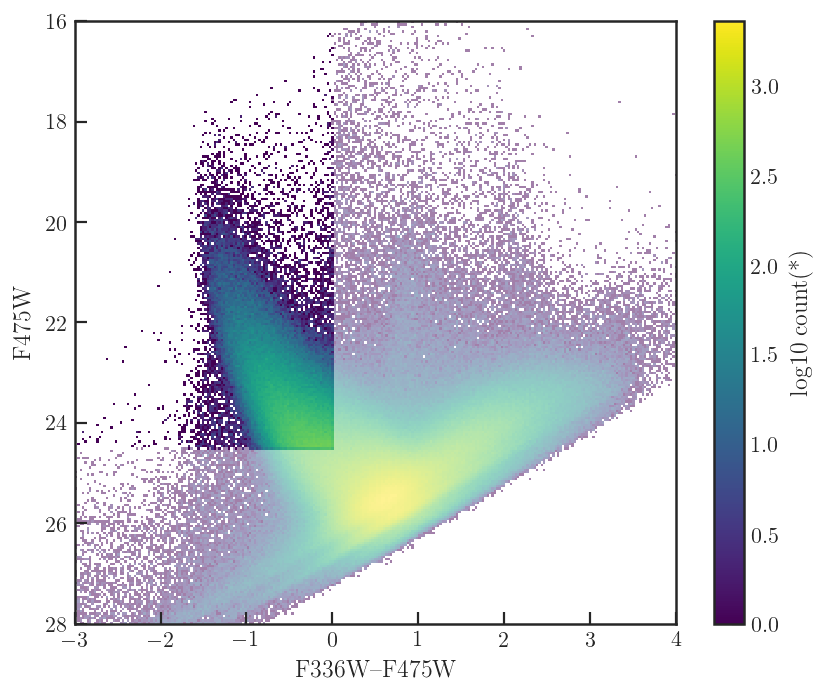

In [25]:
ds_m31.plot('F336W_VEGA-F475W_VEGA', 'F475W_VEGA', f='log10', xlabel='F336W--F475W', ylabel='F475W',
            limits=[[-3,4], [28, 16]], colormap='viridis', figsize=(6,5),
            selection=['F336W_GST & F475W_GST', ob_m31])

In [27]:
ds_m31.selected_length(ob_m31) / 23

9892.391304347826

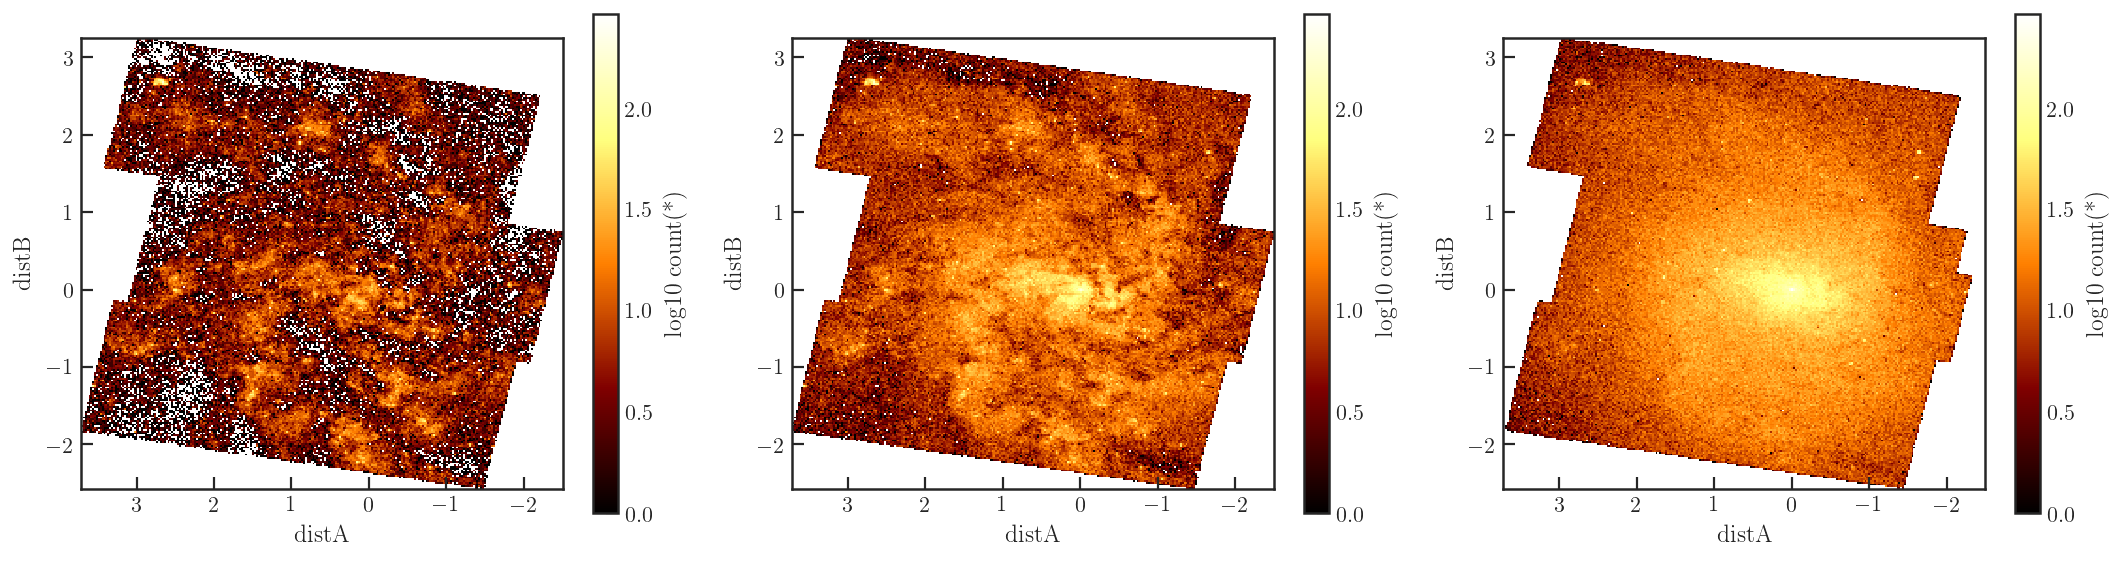

In [55]:
ds.plot('distA', 'distB', f='log10', aspect=1,
        visual=dict(column='selection'), figsize=(15,4),
        selection=['(F275W_VEGA < 24.0) & (F336W_VEGA < 25) & UV_GST',
                   '(F475W_VEGA < 24.5) & (F814W_VEGA < 24) & OPT_GST',
                   '(F110W_VEGA < 22.5) & (F160W_VEGA < 22) & IR_GST'],
)
for ax in plt.gcf().get_axes():
    ax.invert_xaxis()

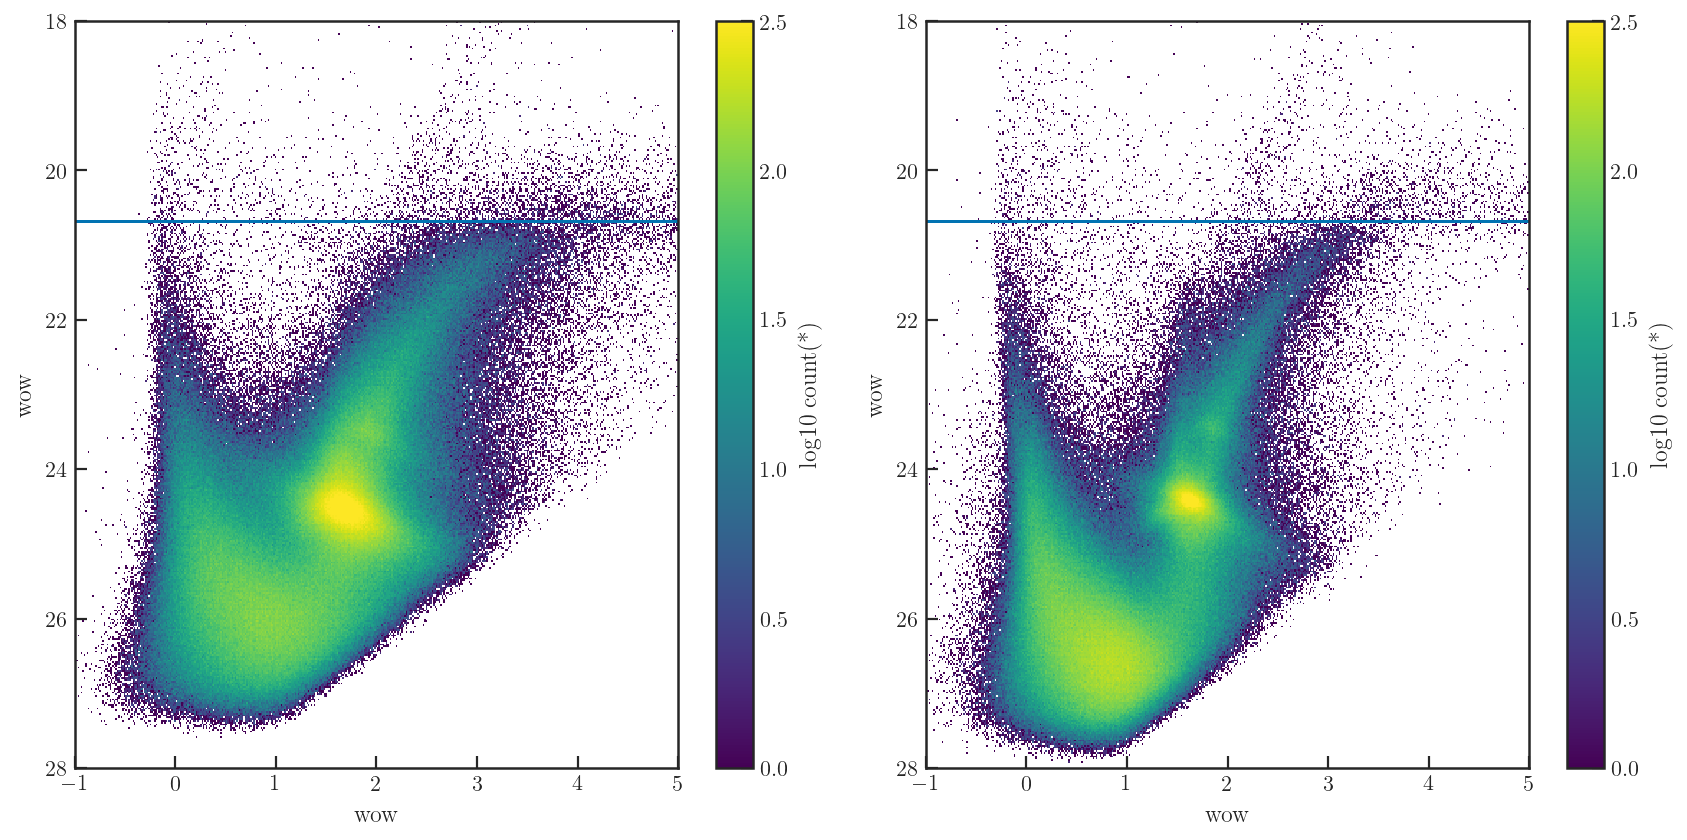

In [63]:
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', f='log10',
        visual=dict(column='selection'), figsize=(12,6),
        selection=['OPT_GST & (radius < 1) & (radius > 0.5)',
                   'OPT_GST & (radius > 3)'],
        xlabel='wow', ylabel='wow', shape=420, colormap='viridis',
        limits=[[-1, 5], [28, 18]], vmin=0, vmax=2.5,
       )
for ax in plt.gcf().get_axes():
    ax.axhline(-4.05+24.67+0.063)